In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import tqdm as notebook_tqdm
import pandas as pd
import datetime
import time
import PIL

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [10]:
# Add module path to sys
module_path = os.path.abspath(os.path.join('..'))
print("System path: "+module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import micro_dl.torch_unet.networks.Unet2D as Unet2D
import micro_dl.torch_unet.networks.Unet25D as Unet25D
import micro_dl.torch_unet.networks.layers.ConvBlock2D as ConvBlock2D
import micro_dl.torch_unet.networks.layers.ConvBlock3D as ConvBlock3D
import micro_dl.torch_unet.utils.dataset as ds
import micro_dl.torch_unet.utils.io as io
import micro_dl.torch_unet.utils.training as training 
import micro_dl.torch_unet.utils.inference as inference

import micro_dl.cli.preprocess_script as preprocess

import micro_dl.utils.aux_utils as aux_utils
import micro_dl.utils.train_utils as train_utils
import micro_dl.utils.preprocess_utils as preprocess_utils


System path: /home/christian.foley/virtual_staining/microDL


### Preprocessing
The tensorflow version of MicroDl's pipeline has a very rich suite of preprocessing (tiling, augmentation, etc) and quality assurance features. They can be called on a dataset through CLI, and are not dependent upon the GPU. Because of this, we can use the current preprocessing to prepare data for our PyTorch model.

Normally, preprocessing would be run through CLI. That would look like: <br>
>```python micro_dl/cli/preprocessing_script.py --config <preprocessing yaml config file>```
>
We can avoid using CLI and get a better look at what the CLI calls by observing what is actually run in [preprocess_script.py](../micro_dl/cli/preprocess_script.py):

```
if __name__ == '__main__':
    args = parse_args()
    preprocess_config = aux_utils.read_config(args.config)
    preprocess_config, runtime = pre_process(preprocess_config)
    save_config(preprocess_config, runtime)
```
So, we just need to generate a config file and pass its filepath.


In [6]:
preprocess_config_file_path = '../micro_dl/config_preprocess_25D.yml'

In [7]:
preprocess_config = yaml.safe_load(open(preprocess_config_file_path, 'r'))
print('input_dir: ', preprocess_config['input_dir'])
print('output_dir: ', preprocess_config['output_dir'])

input_dir:  /hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia/data
output_dir:  /hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia/tile_25D


We can change these to fit our directory. Our output data from preprocessing is tiles of our input data, so let's keep the input and output in the same directory.

In [8]:
experiment_data_dir = '/hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia'
input_dir, output_dir = os.path.join(experiment_data_dir, 'data'), os.path.join(experiment_data_dir, 'tile_25D')

In [9]:
# guarantee that our directories exist
for our_dir in [experiment_data_dir, input_dir, output_dir]:
    if not os.path.exists(our_dir):
        os.makedirs(our_dir)

In [10]:
preprocess_config['input_dir'], preprocess_config['output_dir'] = input_dir, output_dir
print('input_dir: ', preprocess_config['input_dir'])
print('output_dir: ', preprocess_config['output_dir'])

input_dir:  /hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia/data
output_dir:  /hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia/tile_25D


In [11]:
#save our changes into config file
with open(preprocess_config_file_path, 'w') as f:
    yaml.dump(preprocess_config, f)

Now we can run the action items used in the script called in the preprocessing through CLI:

In [12]:
#WARNING: DO NOT RUN MORE THAN ONCE
#Expected runtime ~5-10 minutes
do_preprocessing = False
if do_preprocessing:
    preprocess_config = aux_utils.read_config(preprocess_config_file_path)
    preprocess_config, runtime = preprocess.pre_process(preprocess_config)
    preprocess.save_config(preprocess_config, runtime)

### Format processed data
Similar to preprocessing, the specifications for training are given through a config file:

In [13]:
train_config_file_path = '../micro_dl/config_train_25D_torch.yml'

In [14]:
train_config = yaml.safe_load(open(train_config_file_path, 'r'))
print('data_dir: ', train_config['dataset']['data_dir'])

In [15]:
train_config['dataset']['data_dir'] = os.path.join(output_dir, 'tiles_256-256_step_128-128')
print('new data_dir: ', train_config['dataset']['data_dir'])

In [16]:
#save our changes into config file
with open(train_config_file_path, 'w') as f:
    yaml.dump(train_config, f)

#### Using TorchDataset
We will use the [TorchDataset](../micro_dl/torch_unet/utils/dataset.py) object to convert the dataset created by microDL's tensorflow 1.x dataset creation object into a format usable by the pytorch unet25d.<br>
Note that this allows for all the dataset parameters and augmentation outlined in the old microDL config files to still take place; we are just taking the outputs of those dataloaders and reformatting them. If you would like to know more, further documentation can be found in the implementation.

In [17]:
torch_data_container = ds.TorchDataset(train_config_file_path, 
                                       transforms = [ds.ToTensor()],
                                       target_transforms = [ds.ToTensor(), 
                                                            ds.GenerateMasks(masking_type = 'rosin', clipping = True, clip_amount = (10,0))]) #good practice to put GenerateMasks last in the list of sequential transforms
print(len(torch_data_container))

train_dataset = torch_data_container['train']
test_dataset = torch_data_container['test']
val_dataset = torch_data_container['val']
print(len(train_dataset), len(test_dataset), len(val_dataset))

The data container applies the transformations to all of the dataset objects it returns. We only want to apply thresholding to our training data and targets, so the ds.GenerateMasks transformation appends the dataset minibatch tuple, which we can later access and apply in training. The clip_amount clips a specified percentile of each image before generating the mask. A good value appears to be 10% on bottom end.

# Visualise Data


In [8]:
experiment_data_dir = '/hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia'
input_dir, output_dir = os.path.join(experiment_data_dir, 'data'), os.path.join(experiment_data_dir, 'tile_25D')

In [9]:
# guarantee that our directories exist
for our_dir in [experiment_data_dir, input_dir, output_dir]:
    if not os.path.exists(our_dir):
        os.makedirs(our_dir)

In [10]:
preprocess_config['input_dir'], preprocess_config['output_dir'] = input_dir, output_dir
print('input_dir: ', preprocess_config['input_dir'])
print('output_dir: ', preprocess_config['output_dir'])

input_dir:  /hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia/data
output_dir:  /hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia/tile_25D


In [11]:
#save our changes into config file
with open(preprocess_config_file_path, 'w') as f:
    yaml.dump(preprocess_config, f)

Now we can run the action items used in the script called in the preprocessing through CLI:

In [12]:
#WARNING: DO NOT RUN MORE THAN ONCE
#Expected runtime ~5-10 minutes
do_preprocessing = False
if do_preprocessing:
    preprocess_config = aux_utils.read_config(preprocess_config_file_path)
    preprocess_config, runtime = preprocess.pre_process(preprocess_config)
    preprocess.save_config(preprocess_config, runtime)

### Format processed data
Similar to preprocessing, the specifications for training are given through a config file:

In [13]:
train_config_file_path = '../micro_dl/config_train_25D_torch.yml'

In [14]:
train_config = yaml.safe_load(open(train_config_file_path, 'r'))
print('data_dir: ', train_config['dataset']['data_dir'])

data_dir:  /hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia/tile_25D/tiles_256-256_step_128-128


In [15]:
train_config['dataset']['data_dir'] = os.path.join(output_dir, 'tiles_256-256_step_128-128')
print('new data_dir: ', train_config['dataset']['data_dir'])

new data_dir:  /hpc/projects/compmicro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia/tile_25D/tiles_256-256_step_128-128


In [16]:
#save our changes into config file
with open(train_config_file_path, 'w') as f:
    yaml.dump(train_config, f)

### Get data
We will use the **TorchDataset** object to convert the dataset created by microDL's tensorflow 1.x dataset creation object into a format usable by the pytorch unet25d.<br>
Note that this allows for all the dataset parameters and augmentation outlined in the old microDL config files to still take place; we are just taking the outputs of those dataloaders and reformatting them. Read more in the implementation at **'micro_dl/torch_unet/utils/dataset'**.

In [6]:
config_file_path = '../micro_dl/config_train_25D.yml'

In [7]:
torch_data_container = ds.TorchDataset(config_file_path, 
                                       transforms = [ds.ToTensor()],
                                       target_transforms = [ds.ToTensor(), ds.GenerateMasks(masking_type = 'rosin', clipping = True, clip_amount = (15,0))]) #good practice to put GenerateMasks last in the list of sequential transforms
print(len(torch_data_container))

train_dataset = torch_data_container['train']
test_dataset = torch_data_container['test']
val_dataset = torch_data_container['val']
print(len(train_dataset), len(test_dataset), len(val_dataset))

3
173 20 25


The data container applies the transformations to all of the dataset objects it returns. We only want to apply thresholding to our training data and targets, so the ds.GenerateMasks transformation appends the dataset minibatch tuple, which we can later access and apply in training. The clip_amount clips a specified percentile of each image before generating the mask. A good value appears to be 15.

### Visualise Data
We can plot out the data to view the 5 z slice phase images next to the target that the network needs to translate them into. This is an important step to verify that we are feeding the correct data in the correct orders into the network.

In [8]:
rows = 3
ind = int(np.random.uniform(0, len(train_dataset)))
print(ind)
samp = train_dataset[ind][0].cpu().numpy()[:rows]
targ = train_dataset[ind][1].cpu().numpy() [:rows]
mask = train_dataset[ind][2].cpu().numpy() [:rows]

48


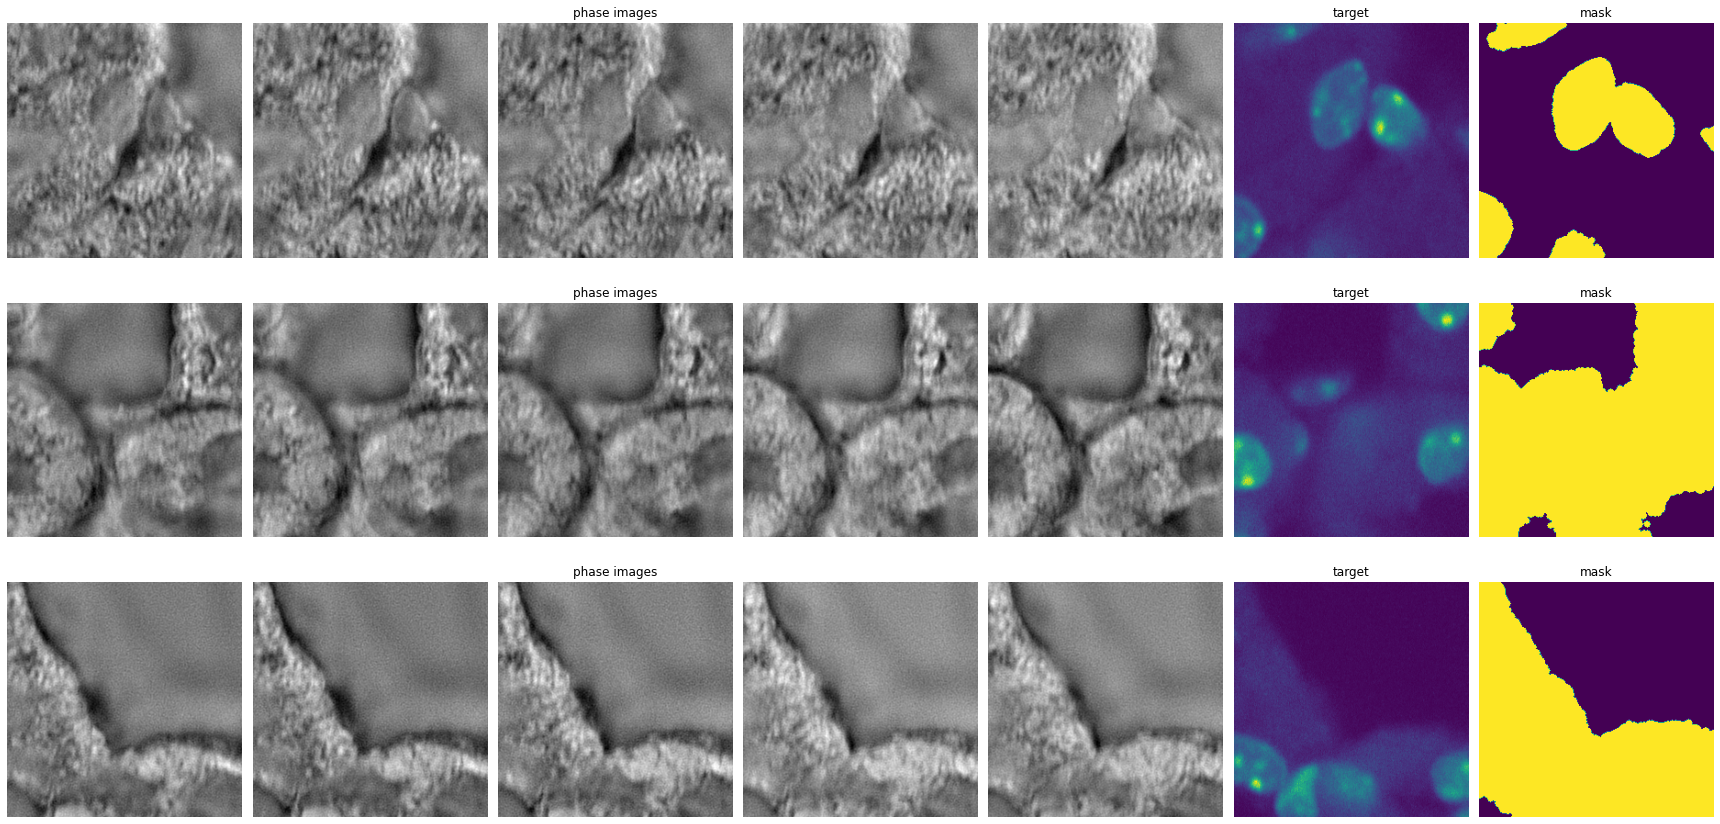

In [11]:
%matplotlib inline
fig, ax = plt.subplots(samp.shape[0],7, figsize = (24,4*samp.shape[0]))

for i in range(samp.shape[0]):
    for j in range(5):
        ax[i][j].imshow(samp[i][0][j], cmap = 'gray')
        if j == 2:
            ax[i][j].set_title('phase images')
        ax[i][j].axis('off')
    ax[i][5].imshow(targ[i][0][0])
    ax[i][5].set_title('target')
    ax[i][5].axis('off')
    ax[i][6].imshow(mask[i][0][0])
    ax[i][6].set_title('mask')
    ax[i][6].axis('off')
    
plt.tight_layout()
plt.show()

We can use these thresholds to trim the clipping value, which will help grow or shrink masked area. We want to capture as much of the cell area as we can, without capturing the background space. Once the data looks like what we expect, we can pass this into our network to try training.

### Training

To train the network we will: <br>
**1.)** Create dataloaders to feed our datasets into the network<br>
**2.)** Define our model and optimization parameters; optimizer, learning rate, loss criterion, etc<br>
**3.)** Define testing protocol <br>
**4.)** Set up save directories for our model and the test results<br>
**5.)** Define and run our training loop<br>

In [12]:
# 1.) DATALOADING

batch_size = 1 # note that the tensorflow dataset already created batched samples. 
               # This means there will be an extra dimension, even with batch_size = 1. 
               # We will remove that dimension on each sample as it enters the network

train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle=True)

In [13]:
# verify our dataloader is working
for sample in train_dataloader:
    sample = sample[0] #remove extra 'batch' dimension
    print(sample[0].shape)
    break

torch.Size([16, 1, 5, 256, 256])


Looks good. Our inputs are in minibatches of **16**, with **1** feature channel, **5** z slice channels, each of which contains a **256x256** image

In [14]:
#2.) MODEL/OPT DEFINITION

#hyperparameters
params = {
    'model': {
        'in_channels': 1,
        'out_channels': 1,
        'residual': True,
        'task': 'reg', #regression
        'device': torch.device('cuda')
    },
    'training': {
        'epochs': 100,
        'learning_rate': 0.0003,
        'optimizer': 'adam',
        'loss': nn.MSELoss,
        'optimizer': optim.Adam,
        'testing_stride': 1
    }
}

In [15]:
#define model
model = Unet25D.Unet25d(in_channels = params['model']['in_channels'], out_channels = params['model']['out_channels'], 
                        residual = params['model']['residual'], task = params['model']['task'])
model.cuda()

Unet25d(
  (down_samp_0): AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0)
  (down_samp_1): AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0)
  (down_samp_2): AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0)
  (down_samp_3): AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0)
  (down_conv_block_0): ConvBlock3D(
    (batch_norm_0): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv3d_0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (Conv3d_1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (Conv3d_2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (resid_conv): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (relu

You may notice that our model layers dont appear to be in order. Don't worry; the order they are listed in is *not* the order they are called in in the forward call. If you want to see more, you can find the model under **'micro_dl/torch_unet/networks/Unet25D.py'**.

In [16]:
#define loss criterion and optimizer
criterion = params['training']['loss']()
optimizer = params['training']['optimizer'](model.parameters(), lr = params['training']['learning_rate'])

In [17]:
print(criterion, optimizer)

MSELoss() Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)


Looks good. Now we define our testing protocols. We will use methods defined in **'micro_dl/torch_unet/utils/training.py'**.

In [18]:
#3.) TESTING CYCLE

testing_cycle = training.run_test
testing_cycle

<function micro_dl.torch_unet.utils.training.run_test(test_dataloader, model, criterion, *, plot=True, plot_num=2, epoch=None, save_folder=None, writer=None, device=device(type='cuda'))>

Note that the testing function assumes our device to be gpu, as does our dataset converter, so thats good.

In [19]:
#4.) SAVE DIRECTORY

now = str(datetime.datetime.now()).replace(' ', '_').replace(':','_').replace('-','_')[:-10]
save_folder = f'/hpc/projects/CompMicro/projects/virtualstaining/torch_microDL_models/Unet25d/training_model_{now}'
print(save_folder)

#we will also define the tensorboard writer here, so it can log the entire training process
writer = SummaryWriter(log_dir = save_folder)

/hpc/projects/CompMicro/projects/virtualstaining/torch_microDL_models/Unet25d/training_model_2022_09_02_16_27


Epoch 0:
	 training 173/173 [==================================================>] (100%)
	 testing 20/20 [==================================================>] (100%)


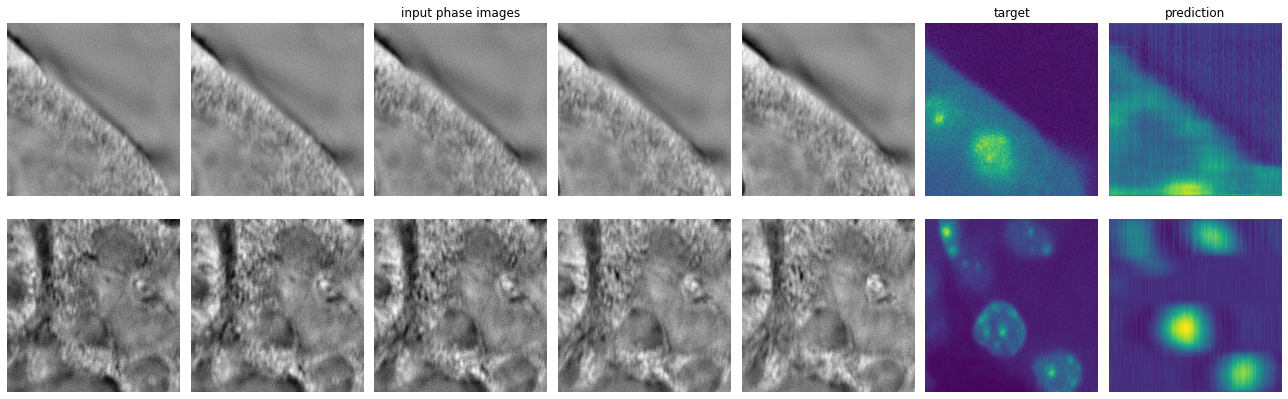

	 Training loss: 0.7663777267312728
	 Testing loss: 0.027544231265783307
	 Epoch time: 145.85399436950684, Total_time: 145.85471844673157
 
Epoch 1:
	 training 173/173 [==================================================>] (100%)


In [ ]:
#5) TRAINING LOOP
start = time.time()
train_loss_list = []
test_loss_list = []
model.train()

for i in range(params['training']['epochs']):
    print(f'Epoch {i}:')
    epoch_time = time.time()
    train_loss = 0
    for current, minibatch in enumerate(train_dataloader): 
        #pretty printing
        training.show_progress_bar(train_dataloader, current)
        
        #get sample and target (remember we remove the extra batch dimension)
        sample = minibatch[0][0].to(params['model']['device']).float()
        target = minibatch[1][0].to(params['model']['device']).float()
        mask = minibatch[2][0].to(params['model']['device']).float()
        
        #mask sample to get input and target
        input_ = torch.mul(sample, mask)
        target_ = torch.mul(target, mask)

        #run through model
        output = model(input_)
        loss = criterion(output, target_)
        train_loss += loss.item()
        
        #optimize on weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss_list.append(train_loss/train_dataset.__len__())
    
    
    #run testing cycle every 'stride' epochs
    if i % 1 == 0:
        model.eval()
        test_loss = testing_cycle(test_dataloader, model, criterion, 
                                  epoch = i, 
                                  save_folder = save_folder,
                                  writer = writer,
                                  device = params['model']['device'])
        model.train()
        test_loss_list.append(test_loss/test_dataset.__len__())
        
    print(f'\t Training loss: {train_loss_list[-1]}')
    if i % 1 == 0:
        print(f'\t Testing loss: {test_loss_list[-1]}')
    print(f'\t Epoch time: {time.time() - epoch_time}, Total_time: {time.time() - start}')
    print(' ')
    
print(f'\t Training complete. Time taken: {time.time()-start}')
plt.figure(figsize = (14,7))
plt.plot(train_loss_list, label = 'training loss')
plt.plot(test_loss_list, label = 'testing loss')
plt.legend()
plt.savefig('training_loss.png')
plt.show()

writer.close()

### Evaluation
We can do a very rough evaluation of the training quality from the loss plots. Note that the testing loss should be lower, since the model is in eval during testing, meaning that it doesn't have training augmentations (dropout, etc)
active.

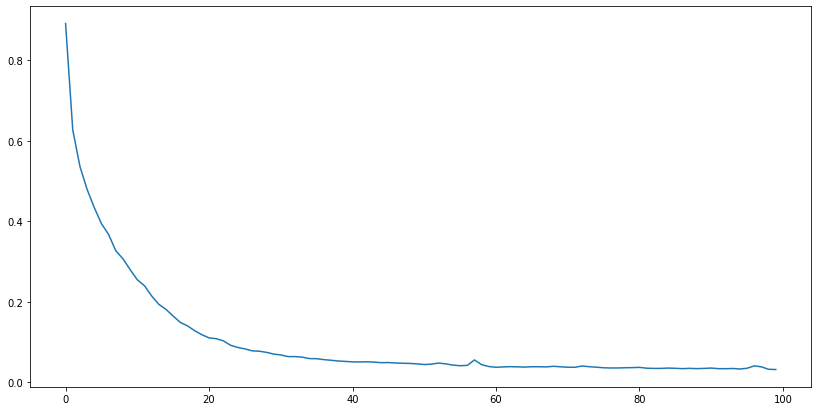

In [75]:
plt.figure(figsize = (14,7))
plt.plot(train_loss_list)

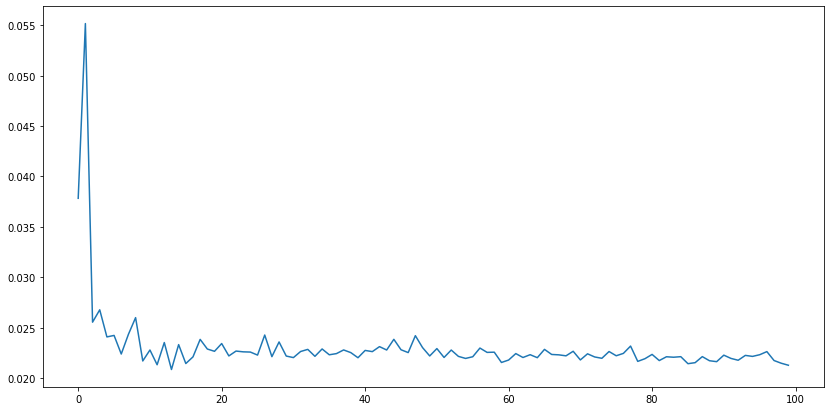

In [73]:
plt.figure(figsize = (14,7))
plt.plot(test_loss_list)

We can also use the validation set to take a look at some outputs:

	 testing 25/25 [==================================================>] (100%)


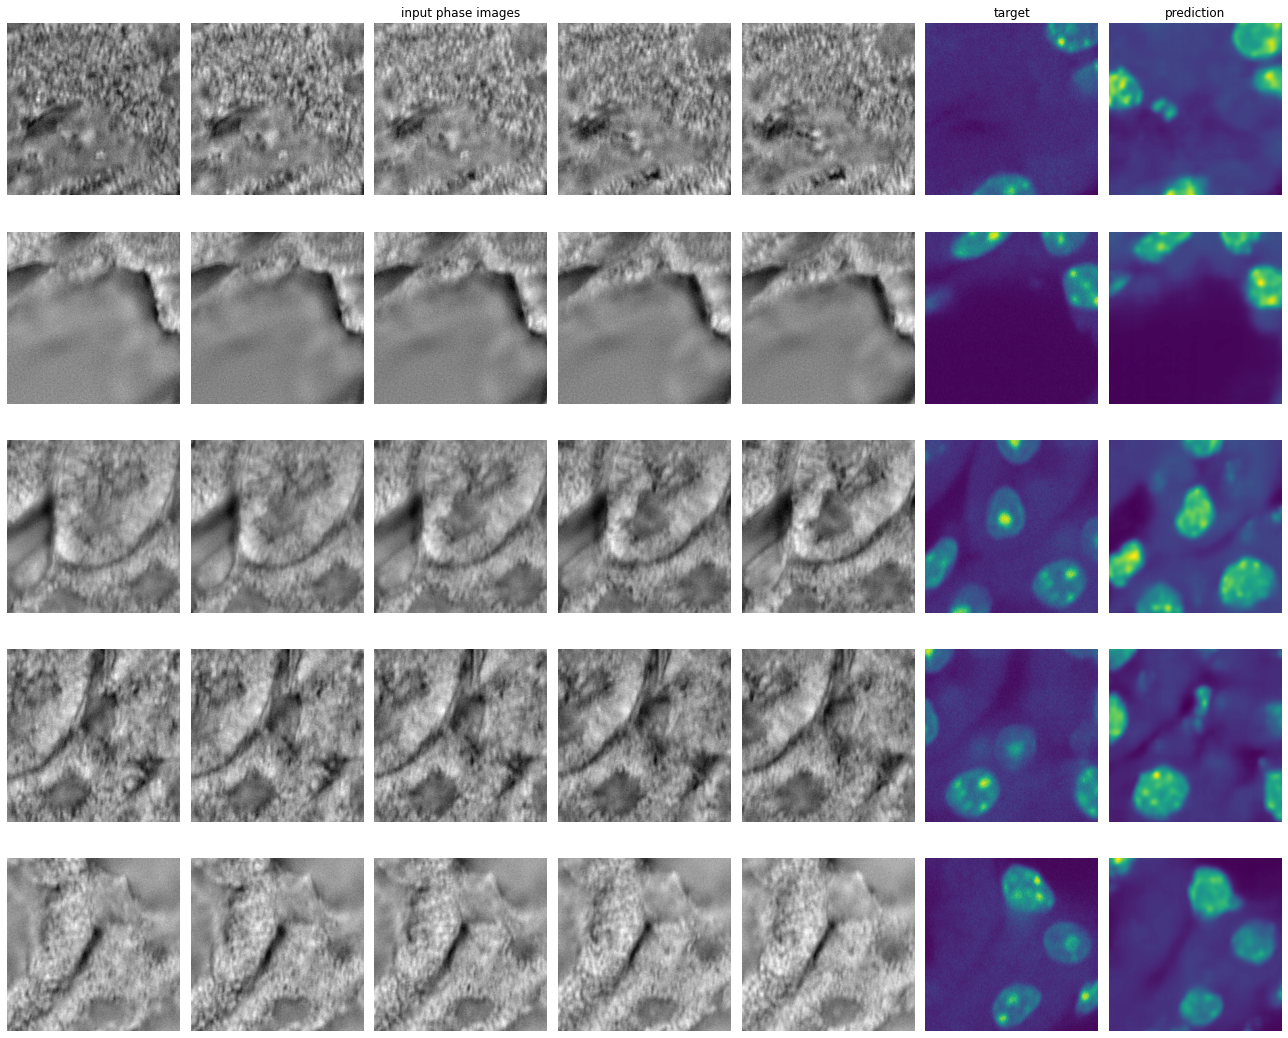

0.37188091516494753

In [61]:
testing_cycle(val_dataloader, model, criterion, plot = True, plot_num = 5)

### Notes on visual evaluation
It appears that the model seems to be learning correctly, and from the loss charts it isn't overfitting either. What does appear to be slightly concerning is the spatial accuracy of the nuclei prediction, as well as the 'hit-rate' for the nuclei labels. As shown in some of the examples above, the prediction labels nuclei that aren't represented in the fluorescence images. I'm not sure (for this dataset specifically) if that is a representation of how well the model is performing, or (conversely), how well the fluorescent reporters are showing the nuclei. It could be that the model picks up nuclei that didn't fluoresce... or it's hallucinating.  <br>
<br>
This data needs to be compared directly to current microDL model predictions using the older tensorflow implementation. We accomplish this by using the [MetricsEstimator](../micro_dl/inference/evaluation_metrics.py) class, which allows us to modularly build and call metrics for evaluation on any two images. <br>
<br>
First we will load a pre-trained tensorflow microDL model, and use this model to perform inference on the entire images using microDL's inference scripts. Because of the cuda-toolkit dependencies, the actual calls must be run on an IBM power i9.

Inference through command line with microDL is run by calling:
>```python micro_dl/cli/inference_script.py --config <train config yml> --gpu <int> --gpu_mem_frac <GPU memory fraction>```
>
Which is interpreted in the [cli script](../micro_dl/cli/inference_script.py) to:
>```if __name__ == '__main__':
>    args = parse_args()
>    # Get GPU ID and memory fraction
>    gpu_id, gpu_mem_frac = train_utils.select_gpu(
>        args.gpu,
>        args.gpu_mem_frac,
>        )
>    run_inference(
>        config_fname=args.config,
>        gpu_ids=gpu_id,
>        gpu_mem_frac=gpu_mem_frac,
>    )```
<br>
The result of this is the predicted image shown below on the right, which is a prediction of the ground truth on the left.

In [ ]:
#get filepaths
prediction_folder = '/hpc/projects/comp_micro/projects/virtualstaining/torch_microDL/models/tensorflow_models/Unet25d/2022_09_08_MBL_kidney_data/predictions/'
data_folder = '/hpc/projects/comp_micro/projects/virtualstaining/torch_microDL/data/2022_09_07_Soorya_KidneyRickettsia/data/'
output_name = 'img_405_t000_p011_z012.tif'
input_names = [f'img_phase_t000_p011_z01{i}.tif' for i in range(5)]

prediction = np.asarray(PIL.Image.open(os.path.join(prediction_folder, output_name)))
target = np.asarray(PIL.Image.open(os.path.join(data_folder, output_name)))
inputs = np.asarray([np.asarray(PIL.Image.open(os.path.join(data_folder, input_name))) for input_name in input_names]).astype('float32')

In [ ]:
#plot pred
fig, ax = plt.subplots(1,3,figsize = (21,7))
ax[0].imshow(np.mean(inputs,0), cmap = 'gray')
ax[0].set_title('average of input phase images')
ax[1].imshow(target)
ax[1].set_title('fluorescence target image')
ax[2].imshow(prediction)
ax[2].set_title('tensorflow prediction')
plt.show()